In [283]:
import pandas as pd
import statsmodels.tsa.stattools as ts

***Testing for Mean Reversion***

A continuous mean-reverting time series can be represented by an Ornstein-Uhlenbeck stochastic differential equation:

$dx_{t} = \theta(\mu - x_{t})dt + \sigma d W_{t}$

Where $\theta$ is the rate of reversion to the mean, $\mu$ is the mean value of the process, $\sigma$ is the variance of the process and $W_{t}$ is a Wiener Process or Brownian Motion.

In a discrete setting the equation states that the change of the price series in the next time period is proportional to the difference between the mean price and the current price, with the addition of Gaussian noise.

This property motivates the Augmented Dickey-Fuller Test, which we will describe below.

***Augmented Dickey-Fuller (ADF) Test***

Mathematically, the ADF is based on the idea of testing for the presence of a unit root in an autoregressive time series sample. It makes use of the fact that if a price series possesses mean reversion, then the next price level will be proportional to the current price level. A linear lag model of order $ p $ is used for the time series:

$\Delta y_{t} = \alpha + \beta t + \gamma y_{t-1} + \delta_{1}\Delta y_{t-1} + ... + \delta_{p-1}\Delta y_{t-p+1} + \epsilon_t$

Where $\alpha$ is a constant, $\beta$ represents the coefficient of a temporal trend and $\Delta y_{t} = y(t) - y(t-1)$. The role of the ADF hypothesis test is to consider the null hypothesis that $\gamma = 0$, which would indicate (with $\alpha = \beta = 0$) that the process is a random walk and thus non mean reverting.

If the hypothesis that $\gamma = 0$ can be rejected then the following movement of the price series is proportional to the current price and thus it is unlikely to be a random walk.

So how is the ADF test carried out? The first task is to calculate the test statistic ($DF_{\tau}$), which is given by the sample proportionality constant $\hat\gamma$ divided by the standard error of the sample proportionality constant:

$DF_{\tau} = \frac {\hat\gamma}{SE(\hat\gamma)}$

Dickey and Fuller have previously calculated the distribution of this test statistic, which allows us to determine the rejection of the hypothesis for any chosen percentage critical value. The test statistic is a negative number and thus in order to be significant beyond the critical values, the number must be more negative than these values, i.e. less than the critical values.

A key practical issue for traders is that any constant long-term drift in a price is of a much smaller magnitude than any short-term fluctuations and so the drift is often assumed to be zero ($\beta = 0$) for the model.

Since we are considering a lag model of order $p$, we need to actually set $p$ to a particular value. It is usually sufficient, for trading research, to set $p = 1$ to allow us to reject the null hypothesis.

In [284]:
def create_dataframe(data_csv):

    # Create a pandas DataFrame containing the Google OHLCV data
    goog = pd.read_csv(data_csv, index_col="Date")
    # Convert index to a Datetime object
    goog.index = pd.to_datetime(goog.index)
    return goog


def augmented_dickey_fuller(goog):
    
    # Output the results of the Augmented Dickey-Fuller test for Google
    # with a lag order value of 1
    adf = ts.adfuller(goog['Adj Close'], 1)
    print(adf)


if __name__ == "__main__":
    data_csv = "https://raw.githubusercontent.com/dymarczykm1/dymarczykm1/main/Data/GOOG.csv"

    goog_df = create_dataframe(data_csv)
    goog_adf = augmented_dickey_fuller(goog_df)

(1.259308326779587, 0.9963710920500263, 1, 4026, {'1%': -3.4319753040982497, '5%': -2.8622581704258483, '10%': -2.56715228954666}, 30818.361054280154)


Here is the output of the Augmented Dickey-Fuller test for Google over the period. The first value is the calculated test-statistic, while the second value is the p-value. The fourth is the number of data points in the sample. The fifth value, the dictionary, contains the critical values of the test-statistic at the 1, 5 and 10 percent values respectively.

Since the calculated value of the test statistic is larger than any of the critical values at the 1, 5 or 10 percent levels, we cannot reject the null hypothesis of $\gamma = 0$ and thus we are unlikely to have found a mean reverting time series.

An alternative means of identifying a mean reverting time series is provided by the concept of stationarity, which we will now discuss.

***Testing for Stationarity***

A time series (or stochastic process) is defined to be strongly stationary if its joint probability distribution is invariant under translations in time or space. In particular, and of key importance for traders, the mean and variance of the process do not change over time or space and they each do not follow a trend. In other words, when you put on a pairs trade, stationary means that the mean and variance of this equation remains constant over time. When you are long one stock and short the other, you are taking the market out of the equation and relying on the mean reverting process to make a gain (sometimes).

A critical feature of stationary price series is that the prices within the series diffuse from their initial value at a rate slower than that of a Geometric Brownian Motion. By measuring the rate of this diffusive behaviour we can identify the nature of the time series.

We will now outline a calculation, namely the Hurst Exponent, which helps us to characterise the stationarity of a time series.

***Hurst Exponent***

The goal of the Hurst Exponent is to provide us with a scalar value that will help us to identify (within the limits of statistical estimation) whether a series is mean reverting, random walking or trending.

The idea behind the Hurst Exponent calculation is that we can use the variance of a log price series to assess the rate of diffusive behaviour. For an arbitrary time lag $\tau$, the variance is given by:

${\rm Var}(\tau) = \langle |\log(t+\tau)-\log(t)|^2 \rangle$

Since we are comparing the rate of diffusion to that of a Geometric Brownian Motion, we can use the fact that at large  we have that the variance is proportional to $\tau$ in the case of a GBM:

$\langle |\log(t+\tau)-\log(t)|^2 \rangle \sim \tau$

The key insight is that if any autocorrelations exist (i.e. any sequential price movements possess non-zero correlation) then the above relationship is not valid. Instead, it can be modified to include an exponent value "$2H$", which gives us the Hurst Exponent value $H$:

$\langle |\log(t+\tau)-\log(t)|^2 \rangle \sim \tau^{2H}$

A time series can then be characterised in the following manner:

 - $H < 0.5$ - The time series is mean reverting
 - $H = 0.5$ - The time series is a Geometric Brownian Motion
 - $H > 0.5$ - The time series is trending

In addition to characterisation of the time series the Hurst Exponent also describes the extent to which a series behaves in the manner categorised. For instance, a value of $H$ near 0 is a highly mean reverting series, while for $H$ near 1 the series is strongly trending.

In [285]:
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn

def hurst(ts):
    
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

# Create a Gometric Brownian Motion, Mean-Reverting and Trending Series
gbm = log(cumsum(randn(100000))+1000)
mr = log(randn(100000)+1000)
tr = log(cumsum(randn(100000)+1)+1000)

# Output the Hurst Exponent for each of the above series
# and the price of Google (the Adjusted Close price) for 
# the ADF test given above in the article
print("Hurst(GBM):   %s" % hurst(gbm))
print("Hurst(MR):    %s" % hurst(mr))
print("Hurst(TR):    %s" % hurst(tr))

# Assuming you have run the above code to obtain 'goog'!
print("Hurst(GOOG):  %s" % hurst(goog_df['Adj Close'].values))

Hurst(GBM):   0.5040261320180033
Hurst(MR):    0.00012571979416835333
Hurst(TR):    0.9579735333655478
Hurst(GOOG):  0.41490391679768046



From this output we can see that the Geometric Brownian Motion posssesses a Hurst Exponent, $H$ , that is almost exactly 0.5. The mean reverting series has $H$ almost equal to zero, while the trending series has $H$ close to 1.

Interestingly, Google has $H$ also approaches 0.5 indicating that it is extremely close to a geometric random walk (at least for the sample period we're making use of!).

While we now have a means of characterising the nature of a price time series, we have yet to discuss how statistically significant this value of $H$ is. We need to be able to determine if we can reject the null hypothesis that $H = 0.5$  to ascertain mean reverting or trending behaviour.

The goal of the Hurst Exponent is to provide us with a scalar value that will help us to identify (within the limits of statistical estimation) whether a series is mean reverting, random walking or trending.

In [286]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm

#Setting seaborn style
sns.set(style='white', palette='bright')

***Cointegration - Pairs Trading***

In this article we will consider another test for mean reversion, namely the Cointegrated Augmented Dickey Fuller (CADF) test.

Firsty, it should be noted that it is actually very difficult to find a directly tradable asset that possesses mean-reverting behaviour. For instance, equities broadly behave like GBMs and hence render the mean-reverting trade strategies relatively useless. However, there is nothing stopping us from creating a portfolio of price series that is stationary. Hence we can apply mean-reverting trading strategies to the portfolio.

The simplest form of mean-reverting trade strategies is the classic "pairs trade", which usually involves a dollar-neutral long-short pair of equities. The theory goes that two companies in the same sector are likely to be exposed to similar market factors, which affect their businesses. Occasionally their relative stock prices will diverge due to certain events, but will revert to the long-running mean.

The function simply plots the two price series on the same chart. This allows us to visually inspect whether any cointegration may be likely.

In [287]:
def plot_price_series(df, ts1, ts2):
    fig, ax = plt.subplots()
    ax.plot(df.index, df[ts1], label=ts1)
    ax.plot(df.index, df[ts2], label=ts2)

    plt.xlabel('Month/Year')
    plt.ylabel('Price ($)')
    plt.title('%s and %s Daily Prices' % (ts1, ts2))
    plt.legend()
    plt.show()

Making a scatterplot allows us to visually inspect whether a linear relationship exists between the two series and thus whether it is a good candidate for the OLS procedure and subsequent ADF test.

In [288]:
def plot_scatter_series(df, ts1, ts2):
    plt.xlabel('%s Price ($)' % ts1)
    plt.ylabel('%s Price ($)' % ts2)
    plt.title('%s and %s Price Scatterplot' % (ts1, ts2))
    plt.scatter(df[ts1], df[ts2])
    plt.show()

Designed to plot the residual values from the fitted linear model of the two price series. This function requires that the pandas DataFrame has a "res" column, representing the residual prices:

In [289]:
def plot_residuals(df):
    fig, ax = plt.subplots()
    ax.plot(df.index, df["res"], label='Residuals', color='b')

    plt.xlabel('Month/Year')
    plt.ylabel('Price ($)')
    plt.title('Residual Plot')
    plt.legend()

    plt.plot(df["res"])
    plt.show()

After the plots are complete the residuals are calculated by calling the pandas OLS function on the EOG and OAS series. This allows us to calculate the $\beta$ hedge ratio. The hedge ratio is then used to create a "res" column via the formation of the linear combination of both WLL and AREX.

Finally the residuals are plotted and the ADF test is carried out on the calculated residuals. We then print the results of the ADF test.

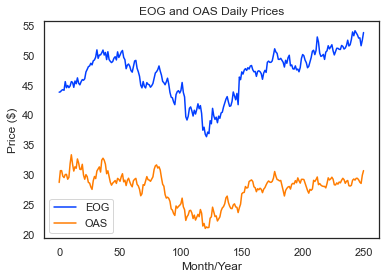

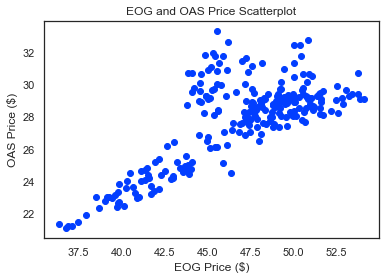

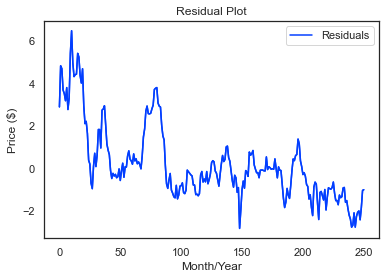

(-3.150764806783532, 0.02301742258175773, 11, 239, {'1%': -3.458010773719797, '5%': -2.8737103617125186, '10%': -2.5732559963936206}, 338.9182948111638)


In [290]:
if __name__ == "__main__":

    eog = pd.read_csv("https://raw.githubusercontent.com/dymarczykm1/dymarczykm1/main/Data/EOG.csv")
    oas = pd.read_csv("https://raw.githubusercontent.com/dymarczykm1/dymarczykm1/main/Data/OAS.csv")

    df = pd.DataFrame(index=oas.index)
    df["EOG"] = eog["Adj Close"]
    df["OAS"] = oas["Adj Close"]

    # Plot the two time series
    plot_price_series(df, "EOG", "OAS")

    # Display a scatter plot of the two time series
    plot_scatter_series(df, "EOG", "OAS")

    # Calculate optimal hedge ratio "beta"
    res = sm.OLS(endog=df["OAS"], exog=df["EOG"]).fit()   

    # Calculate the residuals of the linear combination
    df["res"] = df["OAS"] - 0.59*df["EOG"]

    # Plot the residuals
    plot_residuals(df)

    # Calculate and output the CADF test on the residuals
    cadf = ts.adfuller(df["res"])
    print(cadf)

The pairs trade essentially works by using a linear model for a relationship between the two stock prices:

$y(t) = \beta x(t) + \epsilon(t)$
 
Where $y(t)$ is the price of EOG stock and $x(t)$ is the price of OAS stock, both on day .

If we plot the residuals $\epsilon(t) = y(t) - \beta x(t)$ (for a particular value of  that we will determine below) we create a new time series that can show if the series is stationary or not. 